In [41]:
import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from transformers import AutoModel, AutoTokenizer

In [42]:
# Load Model
model_name = "albert-xlarge-v2"
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Specify Input Text ( max length 512 )
# text = "Insert paragraph from Wikipedia here"
# text = "the the the the the the the the the the the the"

text = """
    In mathematics, the Ornstein–Uhlenbeck process is a stochastic process with applications in financial mathematics and the physical sciences. 
    Its original application in physics was as a model for the velocity of a massive Brownian particle under the influence of friction. 
    It is named after Leonard Ornstein and George Eugene Uhlenbeck.
    
    The Ornstein–Uhlenbeck process is a stationary Gauss–Markov process, 
    which means that it is a Gaussian process, a Markov process, and is temporally homogeneous. 
    In fact, it is the only nontrivial process that satisfies these three conditions, 
    up to allowing linear transformations of the space and time variables.
    Over time, the process tends to drift towards its mean function: such a process is called mean-reverting.
    
    The process can be considered to be a modification of the random walk in continuous time, or Wiener process, 
    in which the properties of the process have been changed so that there is a tendency of the walk to move back towards a central location, 
    with a greater attraction when the process is further away from the center. 
    The Ornstein–Uhlenbeck process can also be considered as the continuous-time analogue of the discrete-time AR(1) process.
    """

text = """
    Humans (Homo sapiens) or modern humans are the most common and widespread species of primate, 
    and the last surviving species of the genus Homo. 
    They are great apes characterized by their hairlessness, bipedalism, and high intelligence. Humans have large brains, 
    enabling more advanced cognitive skills that facilitate successful adaptation to varied environments, development of sophisticated tools, 
    and formation of complex social structures and civilizations.

    Humans are highly social, with individual humans tending to belong to a multi-layered network 
    of distinct social groups — from families and peer groups to corporations and political states. 
    As such, social interactions between humans have established a wide variety of values, social norms, languages, and traditions 
    (collectively termed institutions), each of which bolsters human society. 
    Humans are also highly curious: the desire to understand and influence phenomena 
    has motivated humanity's development of science, technology, philosophy, mythology, religion, and other frameworks of knowledge; 
    humans also study themselves through such domains as anthropology, social science, history, psychology, and medicine. 
    As of 2025, there are estimated to be more than 8 billion humans alive.

    For most of their history, humans were nomadic hunter-gatherers. 
    Humans began exhibiting behavioral modernity about 160,000–60,000 years ago. 
    The Neolithic Revolution occurred independently in multiple locations, the earliest in Southwest Asia 13,000 years ago, 
    and saw the emergence of agriculture and permanent human settlement; in turn, this led to the development of civilization 
    and kickstarted a period of continuous (and ongoing) population growth and rapid technological change. 
    Since then, a number of civilizations have risen and fallen, while a number of sociocultural and technological developments 
    have resulted in significant changes to the human lifestyle.
    """


In [43]:
# Tokenize Input
inputs = tokenizer(text, return_tensors="pt")

# Pass Through Model and Extract Hidden States
with torch.no_grad():
    outputs = model(**inputs)
hidden_states = (
    outputs.hidden_states
)  # List: one tensor per layer (including embedding)

In [44]:
# Compute Pairwise Inner Products Per Layer
def get_pairwise_inner_products(layer_output):
    # layer_output: (batch_size=1, seq_len, hidden_dim)
    X = layer_output.squeeze(0)  # shape: (seq_len, hidden_dim)
    X_norm = X / X.norm(dim=1, keepdim=True)  # normalize for cosine similarity
    sim_matrix = torch.matmul(X_norm, X_norm.T)  # shape: (seq_len, seq_len)
    mask = ~torch.eye(sim_matrix.size(0), dtype=bool)  # exclude diagonal
    return sim_matrix[mask].cpu().numpy()


histograms = [get_pairwise_inner_products(h) for h in hidden_states]

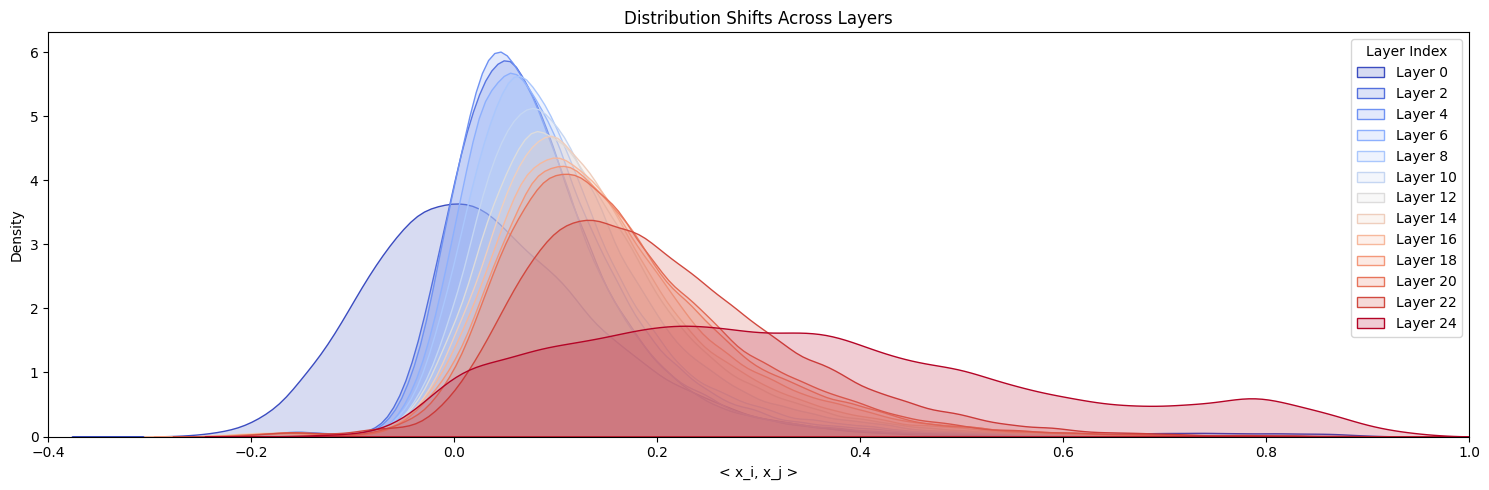

In [45]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Create a colormap that transitions from blue to red
cmap = plt.cm.coolwarm
norm = mcolors.Normalize(vmin=0, vmax=len(histograms) - 1)

# Plot each histogram with a color based on its layer index
for i, hist in enumerate(histograms):
    if i % 2 != 0:
        continue
    color = cmap(norm(i))
    sns.kdeplot(
        hist,
        fill=True,
        alpha=0.2,
        color=color,
        label=f"Layer {i}",
        ax=ax,
        # bw_adjust=0.8,
    )

# Add legend
plt.legend(loc="upper right", title="Layer Index")

# Add color bar to show layer progression
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('Layer Index')

plt.title("Distribution Shifts Across Layers")
plt.xlim(-0.4, 1.0)
plt.xlabel("< x_i, x_j >")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

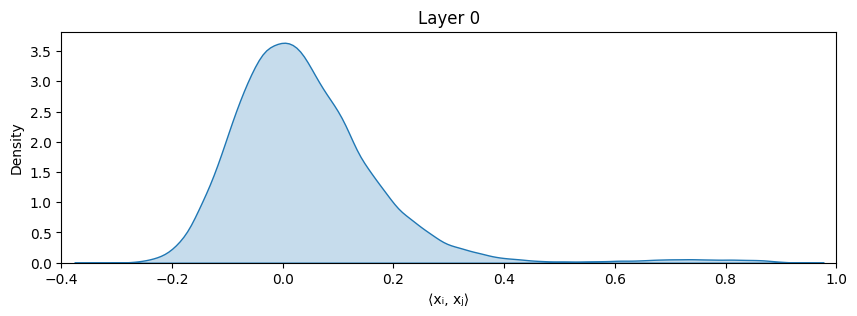

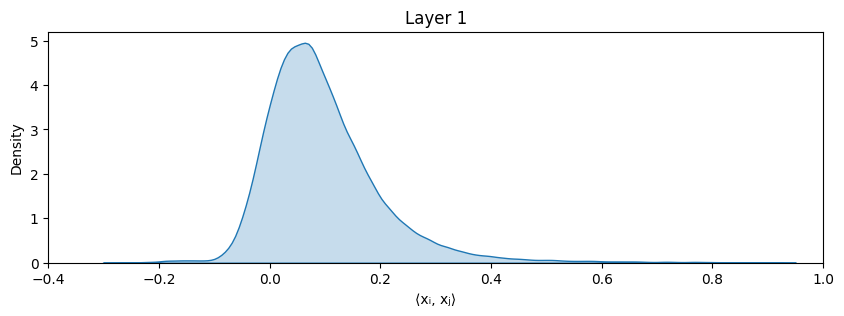

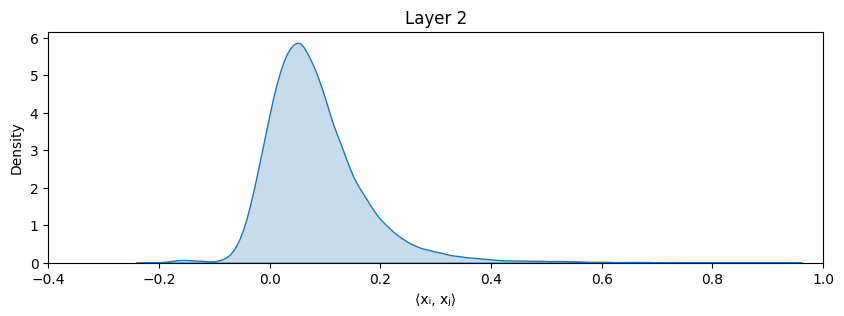

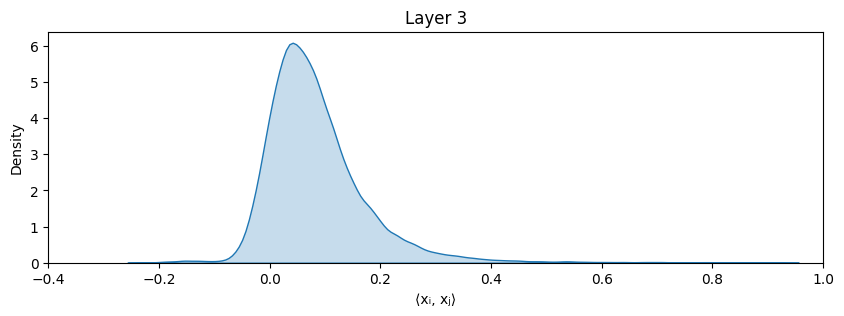

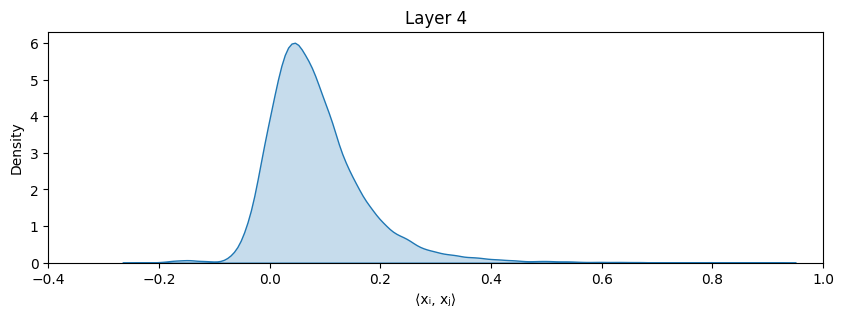

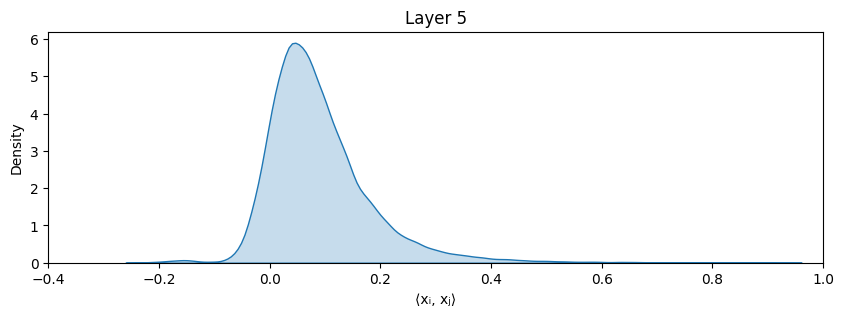

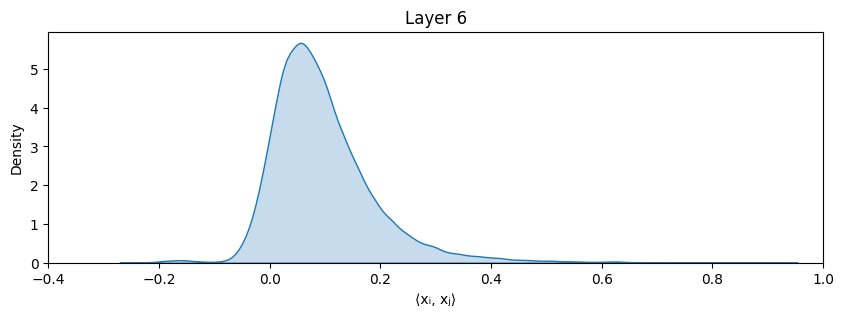

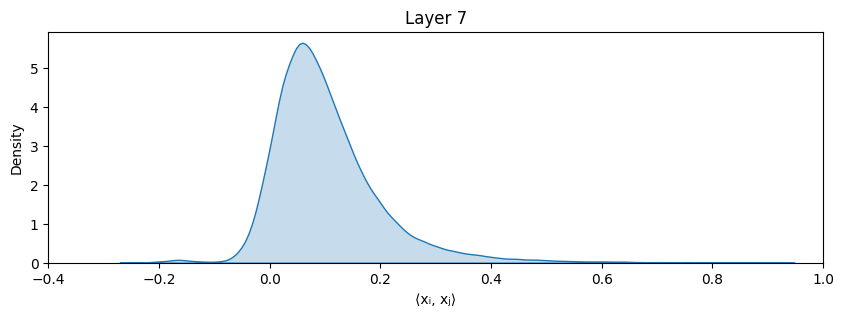

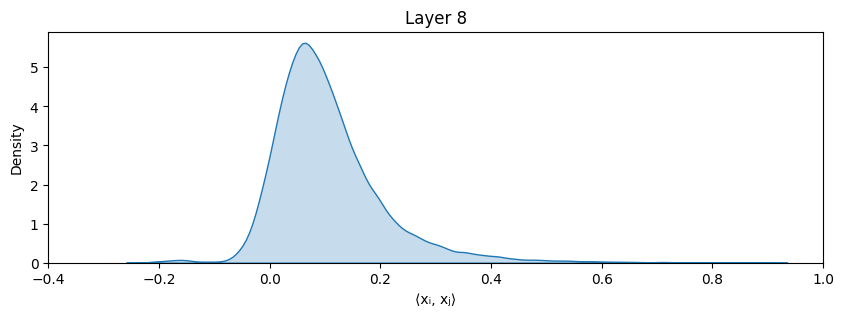

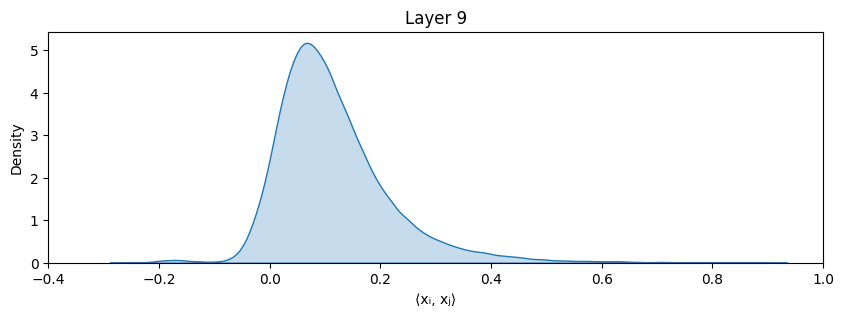

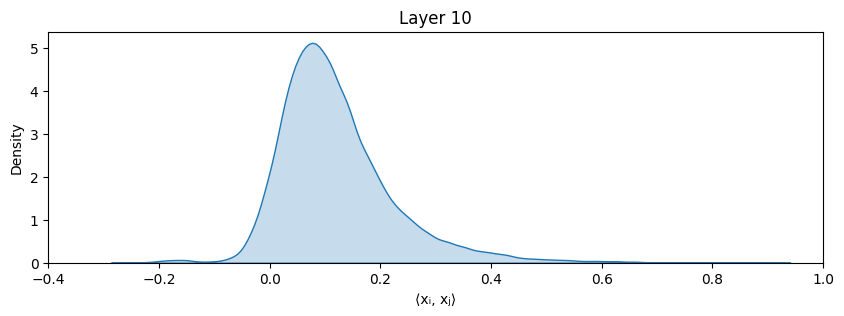

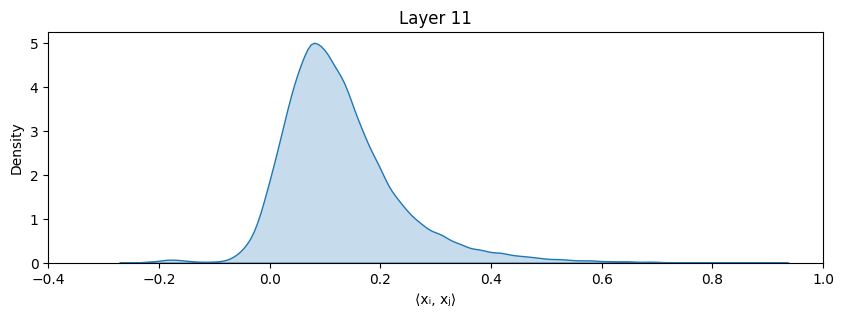

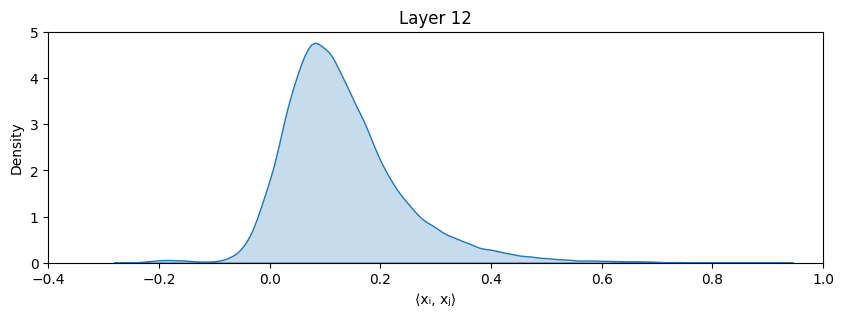

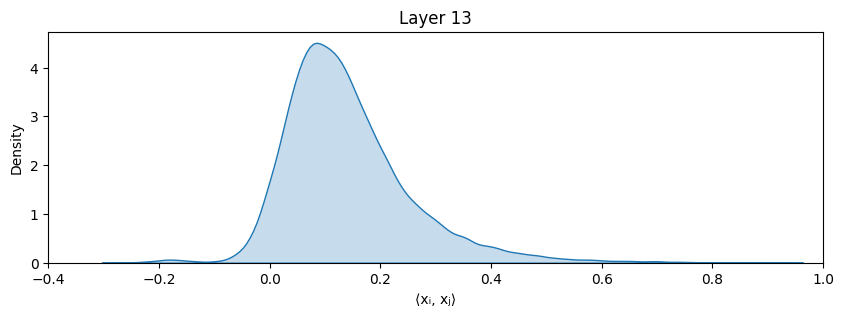

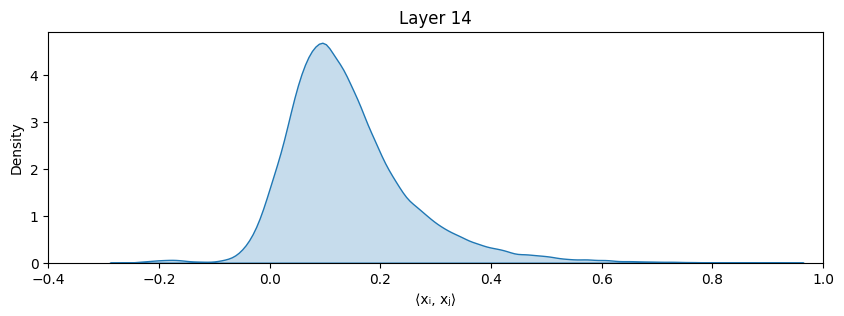

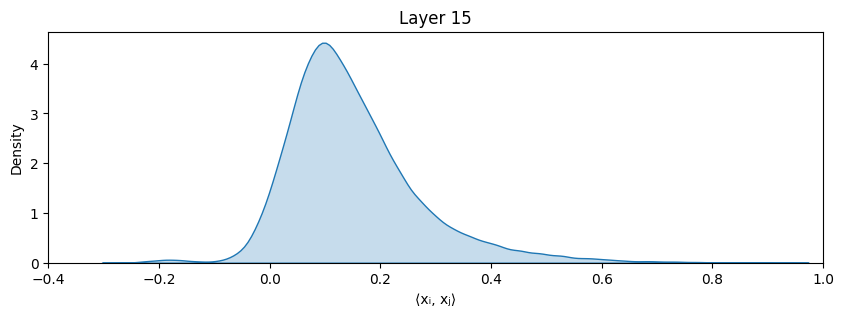

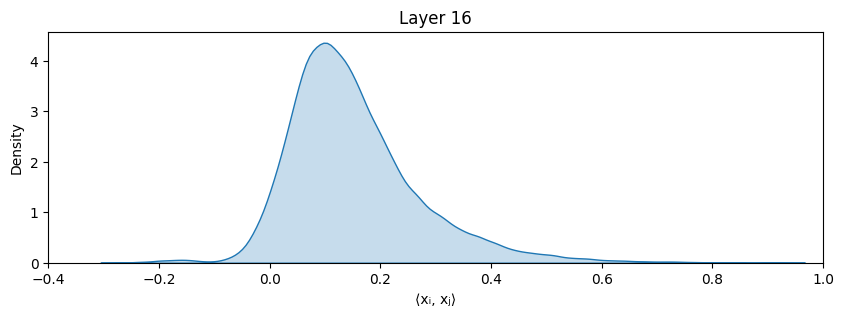

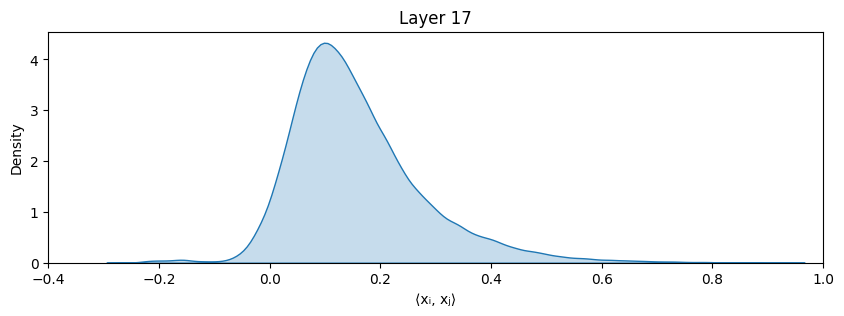

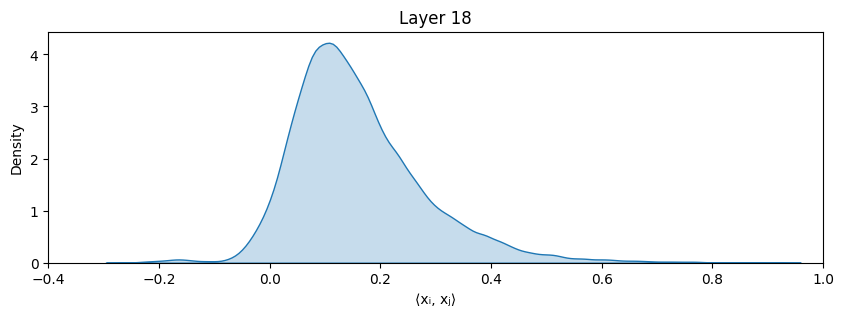

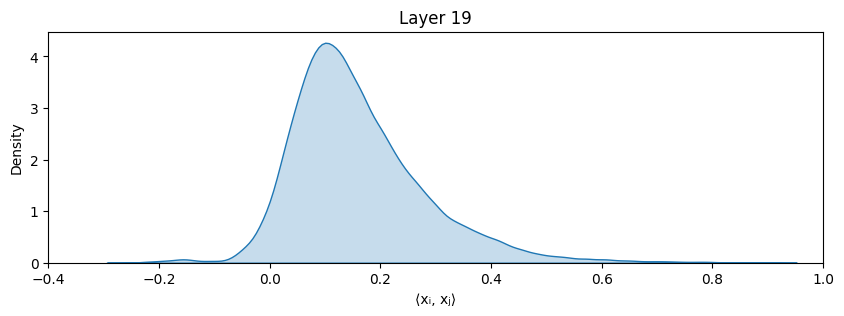

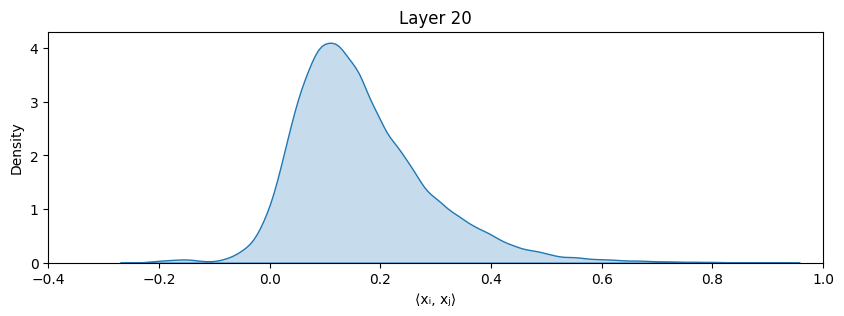

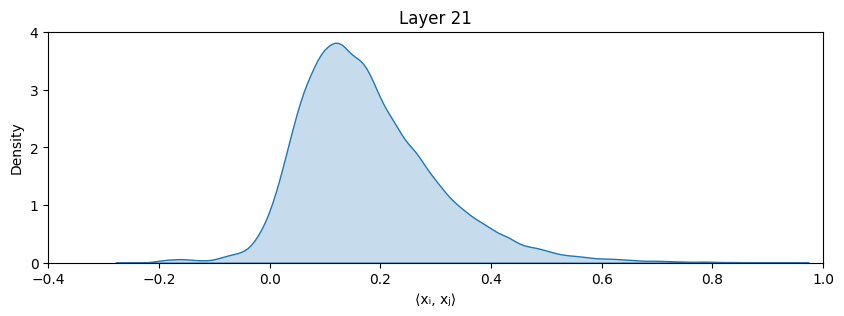

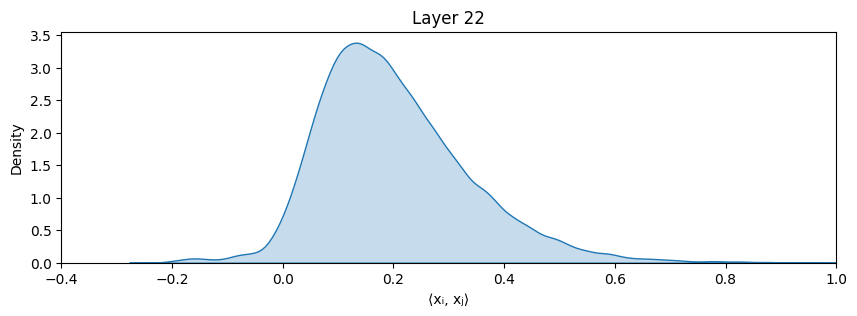

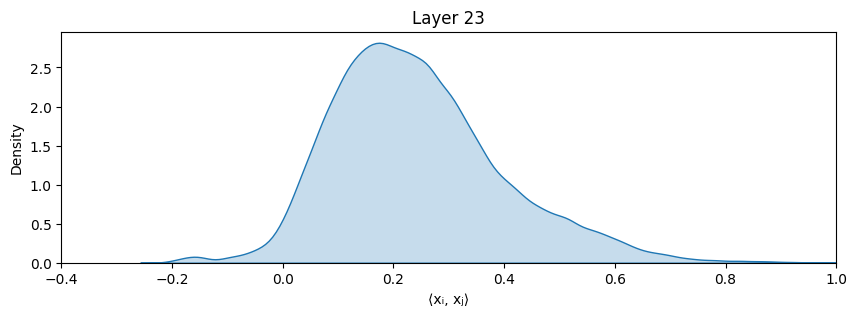

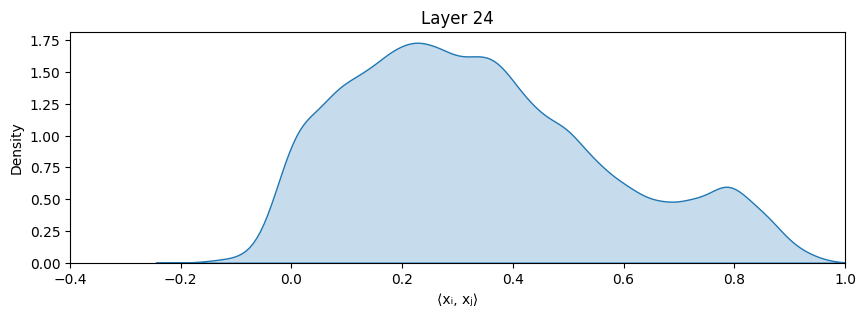

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, hist in enumerate(histograms):
    # if i % 5 != 0:
    #     continue
    plt.figure(figsize=(10, 3))
    sns.kdeplot(hist, fill=True)
    plt.title(f"Layer {i}")
    plt.xlim(-0.4, 1.0)
    plt.xlabel("⟨xᵢ, xⱼ⟩")
    plt.ylabel("Density")
    plt.xlim(-0.4, 1.0)  # or adjust dynamically (see below)
    plt.show()